In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [18]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [19]:
# load and randomize

yelps = pd.read_csv('data/sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('data/sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [20]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

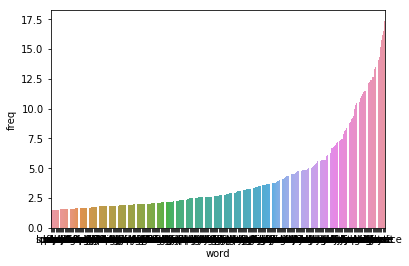

In [6]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

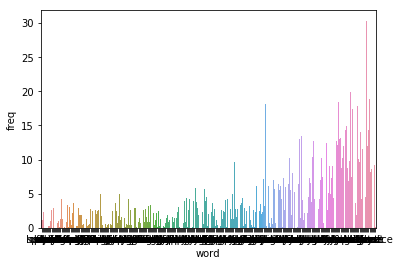

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/oscarmartinez/anaconda3/lib/python3.6/site

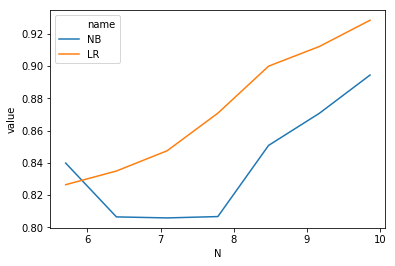

In [9]:
# add vectors here
V = _train_and_transform(yelps.text,vectorizer)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
#models to check: MultinomialNB and LogisticRegression

In [36]:
pipeline_lr=Pipeline([
    ('vect', TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)),
    ('lr',LogisticRegression())   
])

In [46]:
params={'vect__stop_words':('english',None),
        'vect__max_df':(1.0,0.9,0.8),
        'vect__ngram_range':((1,1),(1,2),(1,3)),
        'vect__max_features':(1000,10000),
        'lr__penalty':('l1','l2'),
        'lr__C':(1,0.01,2)
         }

## Grid Search in the yelps dataset

Please note that this grid search was reduced in three ways. One, only using 10000 datapoints out of the 100000 in the dataset. Second, by reducing the cross validation to 2 fold. And last, by reducing the number of parameters the search was done

In [47]:
yelps = yelps.sample(10000)
if __name__ == "__main__":
    
    grid_search = GridSearchCV(pipeline_lr, params, cv=2, 
                               n_jobs=4, verbose=1) #cv should be set higher but for time requirements it's set to 2

    t0 = time()
    grid_search.fit(yelps.text, yelps.positive)
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'lr']
parameters:
{'vect__stop_words': ('english', None), 'vect__max_df': (1.0, 0.9, 0.8), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'vect__max_features': (1000, 10000), 'lr__penalty': ('l1', 'l2'), 'lr__C': (1, 0.01, 2)}
Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.4min
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=4)]: Done 432 out of 432 | elapsed: 53.1min finished
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks l

done in 3197.455s

Best score: 0.934
Best parameters set:
	lr__C: 2
	lr__penalty: 'l2'
	vect__max_df: 0.8
	vect__max_features: 10000
	vect__ngram_range: (1, 2)
	vect__stop_words: None


## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [52]:
# Perform this on a smaller sample of the data to not break your machine
from sklearn.model_selection import train_test_split
from sklearn import metrics
yelps = yelps.sample(10000)
movies = movies.sample(10000)
yelps_text_train,yelps_text_test,yelps_pos_train,yelps_pos_test=train_test_split(yelps.text,yelps.positive,
                                                                                 test_size=0.3,
                                                                                random_state=879)

In [ ]:
vectorizer=TfidfVectorizer(preprocessor = preprocess, min_df = 1, #usign the parameters obtained in the grid search
                           use_idf=False,stop_words=None,
                          max_df=0.8,max_features=10000,ngram_range=(1,2))
lr=LogisticRegression(C=2,penalty='l2')

In [75]:
vectorizer,yelp_tfidf_trans= _train_and_transform(vectorizer, yelps_text_train) #we fit the vectorizer

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [62]:
clf=lr.fit(yelp_tfidf_trans,yelps_pos_train) #we fit the classifier

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [72]:
#classify yelps
yelps_tfidf_pred=yelp_tfidf.transform(yelps_text_test) #transform the test data to predict labels
yelps_predict=clf.predict(yelps_tfidf_pred)

In [74]:
print(metrics.classification_report(yelps_pos_test, yelps_predict))

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      1482
        True       0.95      0.93      0.94      1518

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [66]:
#classify in movies
movies_tfidf_trans=yelp_tfidf.transform(movies.text) #transform the movies data with our trained vectorizer (in yelps)

In [67]:
movies_predict=clf.predict(movies_tfidf_trans) #predict lables with our trained classifier

In [71]:
print(metrics.classification_report(movies.positive, movies_predict))

              precision    recall  f1-score   support

       False       0.73      0.75      0.74      4921
        True       0.75      0.73      0.74      5079

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

